In [2]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import trange
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
# https://www.kaggle.com/code/ivankunyankin/resnet18-from-scratch-using-pytorch#Model
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x
    
class ResNet_18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv1d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm1d(out_channels)
        )

In [21]:
model = ResNet_18(4, 10)
print(model)


ResNet_18(
  (conv1): Conv1d(4, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=Tr

In [4]:
class CSIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [7]:
def importData():
    X_train, X_val, X_test, y_train, y_val, y_test = [], [], [], [], [], []
    for i in range(10):
        temp_train = np.load(f'../data/windtalker_steps/{i}_table_train.npy')
        temp_val = np.load(f'../data/windtalker_steps/{i}_table_val.npy')
        temp_test = np.load(f'../data/windtalker_steps/{i}_table_test.npy')
        if i == 0:
            X_train = temp_train
            X_val = temp_val
            X_test = temp_test
            y_train = np.array([[i] for _ in range(X_train.shape[0])])
            y_val = np.array([[i] for _ in range(X_val.shape[0])])
            y_test = np.array([[i] for _ in range(X_test.shape[0])])
        else:
            X_train = np.append(X_train, temp_train, axis=0)
            X_val = np.append(X_val, temp_val, axis=0)
            X_test = np.append(X_test, temp_test, axis=0)
            y_train = np.append(y_train, np.array([[i] for _ in range(temp_train.shape[0])]), axis=0)
            y_val = np.append(y_val, np.array([[i] for _ in range(temp_val.shape[0])]), axis=0)
            y_test = np.append(y_test, np.array([[i] for _ in range(temp_test.shape[0])]), axis=0)
            
    return X_train, X_val, X_test, y_train, y_val, y_test

In [8]:
class RunningAverage:
    def __init__(self):
        self.steps = 0
        self.total = 0

    def update(self, val):
        self.total += val
        self.steps += 1

    def __call__(self):
        return self.total / float(self.steps)

def accuracy(outputs, labels):
    # outputs (predicted), labels (true)
    outputs = np.argmax(outputs.cpu().detach().numpy(), axis=1)
    labels = labels.squeeze()
    # compare outputs with labels
    return np.sum([1 if first == second else 0 for first, second in zip(labels, outputs)]) / float(len(labels))

In [9]:
def train(model, optimizer, trainLoader, loss_fn, iterations):
    model.train()
    train_loss = RunningAverage()
    train_acc = RunningAverage()
    
    with trange(iterations) as pbar:
        for X_batch, y_batch in trainLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss.update(loss)
            train_acc.update(accuracy(y_pred, y_batch))
            pbar.update(1)
            
    return train_loss(), train_acc()
    
def eval(model, valLoader, loss_fn):
    model.eval()
    eval_loss = RunningAverage()
    eval_acc = RunningAverage()
    
    with torch.no_grad():
        for X_batch, y_batch in valLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            
            eval_loss.update(loss)
            eval_acc.update(accuracy(y_pred, y_batch))
            
    return eval_loss(), eval_acc()
    
def test(model, testLoader, test_size):
    model.eval()
    for X_batch, y_batch in testLoader:
        y_batch = y_batch.type(torch.LongTensor).squeeze(1)
        logits = model(X_batch)
        y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
        
    print(f"Overall Accuracy: {accuracy(y_pred, y_batch):.3f}")

    # True positive percentage
    percentages = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
    # outputs (predicted), labels (true)
    outputs = np.argmax(y_pred.cpu().detach().numpy(), axis=1)
    labels = y_batch.squeeze()
    
    for i in range(len(outputs)):
        if outputs[i] == labels[i]:
            percentages[outputs[i]] += 1
    
    # plot the percentages of correct predictions
    y_percent = [(value/(test_size/10))*100 for key, value in percentages.items()]
    x_label = [str(key) for key, _ in percentages.items()]
    
    fig, test = plt.subplots(figsize=(10,6))
    test.bar(x_label, y_percent)
    test.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Key")
    plt.title("Accuracy (%) per key")
    plt.savefig("percentage_correct_denoised_butter_resnet.png", bbox_inches='tight')
    plt.show()
    
    cm = confusion_matrix(y_true=labels, y_pred=outputs)
    cm = np.divide(cm, (test_size/10))
    
    plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.savefig("confusion_matrix_denoised_butter_resnet.png", bbox_inches='tight')
    plt.show()
    
    print(f"Accuracy for each key: {''.join([x + ': ' + str(round(y, 3)) + '% ' for x, y in zip(x_label, y_percent)])}")
    
    print(classification_report(y_true=labels, y_pred=outputs, target_names=x_label))

In [10]:
def train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss_fn, iterations):
    # for plotting the loss and accuracy
    train_loss_list, train_acc_list, eval_loss_list, eval_acc_list  = [], [], [], []
        
    for epoch in range(epochs):
        train_loss, train_acc = train(model, optimizer, trainLoader, loss_fn, iterations)
        eval_loss, eval_acc = eval(model, valLoader, loss_fn)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        eval_loss_list.append(eval_loss)
        eval_acc_list.append(eval_acc)
        
        print(f"Train: Epoch {epoch}: Loss {train_loss}, Accuracy {train_acc}")
        print(f"Eval: Epoch {epoch}: Loss {eval_loss}, Accuracy {eval_acc}")
        
    return train_loss_list, train_acc_list, eval_loss_list, eval_acc_list
        

In [11]:
def plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs):
    x = [i for i in range(1, epochs+1)]
    
    fig, loss = plt.subplots(figsize=(10,6))
    loss.plot(x, [trainLoss.item() for trainLoss in train_loss_list], label="Training Loss")
    loss.plot(x, [evalLoss.item() for evalLoss in eval_loss_list], label="Validation Loss")
    plt.legend()
    plt.ylabel("Average Loss")
    plt.xlabel("Epochs")
    plt.title("Average Loss per epoch")
    plt.savefig("loss_per_epoch_denoised_butter_resnet.png", bbox_inches='tight')
    
    plt.show()
    
    fig, acc = plt.subplots(figsize=(10,6))
    acc.plot(x, [trainAcc.item() for trainAcc in train_acc_list], label="Training Accuracy")
    acc.plot(x, [evalAcc.item() for evalAcc in eval_acc_list], label="Validation Accuracy")
    plt.legend()
    plt.ylabel("Average Accuracy")
    plt.xlabel("Epochs")
    plt.title("Average Accuracy per epoch")
    plt.savefig("acc_per_epoch_denoised_butter_resnet.png", bbox_inches='tight')
    plt.show()

In [12]:
def print_model_parameters(model):
    total_parameters = 0
    print(" "*20 + "Model Parameters" + " "*20)
    print("="*57)
    print(f"{'Layer':<25}" + "| Parameters")
    print("="*57)
    for name, param in model.named_parameters():
        temp = 1
        temp_list = []
        if param.requires_grad:
            print(f"{name:<25}", end="")
            for i in param.data.shape:
                temp *= i
                temp_list.append(str(i))
            print(": ", end="")
            if len(temp_list) > 1:
                print(f"{' * '.join(temp_list)}", end="")
                print(" = " + str(temp))
            else:
                print(f"{''.join(temp_list)}")

        total_parameters += temp
        
    print("="*57)
    print(f"{'Total parameters':<25}" + f": {total_parameters}")
    print("="*57)

100%|██████████| 110/110 [00:13<00:00,  7.94it/s]


Train: Epoch 0: Loss 2.4097771644592285, Accuracy 0.09905303030303031
Eval: Epoch 0: Loss 2.40004563331604, Accuracy 0.1015625


100%|██████████| 110/110 [00:18<00:00,  6.09it/s]


Train: Epoch 1: Loss 2.058457851409912, Accuracy 0.27651515151515155
Eval: Epoch 1: Loss 2.487967014312744, Accuracy 0.1162109375


100%|██████████| 110/110 [00:12<00:00,  8.50it/s]


Train: Epoch 2: Loss 1.6949542760849, Accuracy 0.44289772727272725
Eval: Epoch 2: Loss 2.7362685203552246, Accuracy 0.103515625


100%|██████████| 110/110 [00:12<00:00,  8.82it/s]


Train: Epoch 3: Loss 1.1772997379302979, Accuracy 0.6259469696969697
Eval: Epoch 3: Loss 3.215904951095581, Accuracy 0.0966796875


100%|██████████| 110/110 [00:12<00:00,  8.55it/s]


Train: Epoch 4: Loss 0.7445563077926636, Accuracy 0.7736742424242424
Eval: Epoch 4: Loss 3.545886754989624, Accuracy 0.1123046875


100%|██████████| 110/110 [00:12<00:00,  8.75it/s]


Train: Epoch 5: Loss 0.43291234970092773, Accuracy 0.8793560606060606
Eval: Epoch 5: Loss 3.9006776809692383, Accuracy 0.1015625


100%|██████████| 110/110 [00:11<00:00,  9.19it/s]


Train: Epoch 6: Loss 0.3026227056980133, Accuracy 0.9126893939393939
Eval: Epoch 6: Loss 4.10198450088501, Accuracy 0.0810546875


100%|██████████| 110/110 [00:12<00:00,  8.97it/s]


Train: Epoch 7: Loss 0.25653600692749023, Accuracy 0.9277462121212121
Eval: Epoch 7: Loss 4.12247371673584, Accuracy 0.09375


100%|██████████| 110/110 [00:12<00:00,  9.11it/s]


Train: Epoch 8: Loss 0.22699865698814392, Accuracy 0.9339962121212121
Eval: Epoch 8: Loss 4.479313850402832, Accuracy 0.0908203125


100%|██████████| 110/110 [00:12<00:00,  9.07it/s]


Train: Epoch 9: Loss 0.19413459300994873, Accuracy 0.9464015151515152
Eval: Epoch 9: Loss 4.514860153198242, Accuracy 0.0849609375


100%|██████████| 110/110 [00:12<00:00,  9.00it/s]


Train: Epoch 10: Loss 0.1587381660938263, Accuracy 0.953219696969697
Eval: Epoch 10: Loss 4.589552879333496, Accuracy 0.1044921875


100%|██████████| 110/110 [00:12<00:00,  9.16it/s]


Train: Epoch 11: Loss 0.14109858870506287, Accuracy 0.9603219696969697
Eval: Epoch 11: Loss 4.731523513793945, Accuracy 0.095703125


100%|██████████| 110/110 [00:12<00:00,  9.06it/s]


Train: Epoch 12: Loss 0.13943085074424744, Accuracy 0.9581439393939394
Eval: Epoch 12: Loss 4.978394031524658, Accuracy 0.1005859375


100%|██████████| 110/110 [00:12<00:00,  9.05it/s]


Train: Epoch 13: Loss 0.16756300628185272, Accuracy 0.9497159090909091
Eval: Epoch 13: Loss 4.951968193054199, Accuracy 0.0927734375


100%|██████████| 110/110 [00:12<00:00,  8.71it/s]


Train: Epoch 14: Loss 0.22537195682525635, Accuracy 0.9231060606060606
Eval: Epoch 14: Loss 4.954195976257324, Accuracy 0.1064453125


100%|██████████| 110/110 [00:12<00:00,  8.52it/s]


Train: Epoch 15: Loss 0.1951444149017334, Accuracy 0.940625
Eval: Epoch 15: Loss 5.003294467926025, Accuracy 0.103515625


100%|██████████| 110/110 [00:12<00:00,  8.50it/s]


Train: Epoch 16: Loss 0.16171279549598694, Accuracy 0.9457386363636363
Eval: Epoch 16: Loss 5.219823360443115, Accuracy 0.10546875


100%|██████████| 110/110 [00:12<00:00,  8.64it/s]


Train: Epoch 17: Loss 0.1537051796913147, Accuracy 0.949905303030303
Eval: Epoch 17: Loss 5.202880382537842, Accuracy 0.09375


100%|██████████| 110/110 [00:13<00:00,  8.37it/s]


Train: Epoch 18: Loss 0.14919497072696686, Accuracy 0.9538825757575757
Eval: Epoch 18: Loss 5.282865047454834, Accuracy 0.099609375


100%|██████████| 110/110 [00:13<00:00,  8.45it/s]


Train: Epoch 19: Loss 0.12805400788784027, Accuracy 0.9609848484848484
Eval: Epoch 19: Loss 5.314141750335693, Accuracy 0.1005859375


100%|██████████| 110/110 [00:13<00:00,  8.34it/s]


Train: Epoch 20: Loss 0.08764853328466415, Accuracy 0.9711174242424243
Eval: Epoch 20: Loss 5.34459114074707, Accuracy 0.1044921875


100%|██████████| 110/110 [00:12<00:00,  8.54it/s]


Train: Epoch 21: Loss 0.07812079787254333, Accuracy 0.9765151515151516
Eval: Epoch 21: Loss 5.324421405792236, Accuracy 0.09765625


100%|██████████| 110/110 [00:13<00:00,  8.34it/s]


Train: Epoch 22: Loss 0.06051744893193245, Accuracy 0.9839015151515152
Eval: Epoch 22: Loss 5.312020301818848, Accuracy 0.107421875


100%|██████████| 110/110 [00:12<00:00,  8.54it/s]


Train: Epoch 23: Loss 0.0498557947576046, Accuracy 0.9854166666666666
Eval: Epoch 23: Loss 5.495635986328125, Accuracy 0.09375


100%|██████████| 110/110 [00:12<00:00,  8.47it/s]


Train: Epoch 24: Loss 0.06833840906620026, Accuracy 0.9765151515151516
Eval: Epoch 24: Loss 5.548907279968262, Accuracy 0.1083984375


100%|██████████| 110/110 [00:13<00:00,  8.45it/s]


Train: Epoch 25: Loss 0.07426506280899048, Accuracy 0.9767992424242424
Eval: Epoch 25: Loss 5.847596645355225, Accuracy 0.08984375


100%|██████████| 110/110 [00:13<00:00,  8.38it/s]


Train: Epoch 26: Loss 0.0799880251288414, Accuracy 0.9743371212121211
Eval: Epoch 26: Loss 5.864375114440918, Accuracy 0.0869140625


100%|██████████| 110/110 [00:13<00:00,  8.32it/s]


Train: Epoch 27: Loss 0.10096157342195511, Accuracy 0.9678977272727273
Eval: Epoch 27: Loss 5.924046516418457, Accuracy 0.0966796875


100%|██████████| 110/110 [00:13<00:00,  8.42it/s]


Train: Epoch 28: Loss 0.2465856522321701, Accuracy 0.9178030303030302
Eval: Epoch 28: Loss 5.884312629699707, Accuracy 0.0830078125


100%|██████████| 110/110 [00:13<00:00,  8.36it/s]


Train: Epoch 29: Loss 0.22962208092212677, Accuracy 0.9233901515151516
Eval: Epoch 29: Loss 5.717959403991699, Accuracy 0.107421875


100%|██████████| 110/110 [00:13<00:00,  8.43it/s]


Train: Epoch 30: Loss 0.13502123951911926, Accuracy 0.956344696969697
Eval: Epoch 30: Loss 5.649845600128174, Accuracy 0.08984375


100%|██████████| 110/110 [00:16<00:00,  6.58it/s]


Train: Epoch 31: Loss 0.09385262429714203, Accuracy 0.9723484848484848
Eval: Epoch 31: Loss 5.767525672912598, Accuracy 0.0810546875


100%|██████████| 110/110 [00:13<00:00,  8.00it/s]


Train: Epoch 32: Loss 0.09230455011129379, Accuracy 0.9722537878787879
Eval: Epoch 32: Loss 5.748433589935303, Accuracy 0.111328125


100%|██████████| 110/110 [00:13<00:00,  7.98it/s]


Train: Epoch 33: Loss 0.04698861762881279, Accuracy 0.9865530303030302
Eval: Epoch 33: Loss 5.80410623550415, Accuracy 0.0947265625


100%|██████████| 110/110 [00:13<00:00,  8.06it/s]


Train: Epoch 34: Loss 0.04761577770113945, Accuracy 0.9877840909090909
Eval: Epoch 34: Loss 5.7850661277771, Accuracy 0.0966796875


100%|██████████| 110/110 [00:13<00:00,  7.97it/s]


Train: Epoch 35: Loss 0.052778035402297974, Accuracy 0.9815340909090909
Eval: Epoch 35: Loss 5.844953536987305, Accuracy 0.0830078125


100%|██████████| 110/110 [00:12<00:00,  8.51it/s]


Train: Epoch 36: Loss 0.03608787804841995, Accuracy 0.9897727272727272
Eval: Epoch 36: Loss 5.972491264343262, Accuracy 0.0830078125


100%|██████████| 110/110 [00:12<00:00,  8.72it/s]


Train: Epoch 37: Loss 0.03876466304063797, Accuracy 0.9875
Eval: Epoch 37: Loss 6.0875468254089355, Accuracy 0.0849609375


100%|██████████| 110/110 [00:12<00:00,  8.61it/s]


Train: Epoch 38: Loss 0.04786507040262222, Accuracy 0.9850378787878789
Eval: Epoch 38: Loss 6.157243251800537, Accuracy 0.076171875


100%|██████████| 110/110 [00:13<00:00,  8.15it/s]


Train: Epoch 39: Loss 0.11489164084196091, Accuracy 0.9654356060606061
Eval: Epoch 39: Loss 6.3135151863098145, Accuracy 0.0771484375


100%|██████████| 110/110 [00:13<00:00,  8.31it/s]


Train: Epoch 40: Loss 0.1544908732175827, Accuracy 0.9502840909090909
Eval: Epoch 40: Loss 6.290309906005859, Accuracy 0.087890625


100%|██████████| 110/110 [00:13<00:00,  8.45it/s]


Train: Epoch 41: Loss 0.17943120002746582, Accuracy 0.9444128787878788
Eval: Epoch 41: Loss 6.002988338470459, Accuracy 0.087890625


100%|██████████| 110/110 [00:13<00:00,  8.43it/s]


Train: Epoch 42: Loss 0.10801491886377335, Accuracy 0.9637310606060606
Eval: Epoch 42: Loss 6.01605224609375, Accuracy 0.08984375


100%|██████████| 110/110 [00:13<00:00,  7.97it/s]


Train: Epoch 43: Loss 0.06341787427663803, Accuracy 0.978125
Eval: Epoch 43: Loss 5.913475513458252, Accuracy 0.08984375


100%|██████████| 110/110 [00:13<00:00,  8.45it/s]


Train: Epoch 44: Loss 0.09874025732278824, Accuracy 0.9671401515151515
Eval: Epoch 44: Loss 6.060119152069092, Accuracy 0.1025390625


100%|██████████| 110/110 [00:12<00:00,  8.49it/s]


Train: Epoch 45: Loss 0.07258543372154236, Accuracy 0.9771780303030303
Eval: Epoch 45: Loss 5.921055316925049, Accuracy 0.095703125


100%|██████████| 110/110 [00:13<00:00,  8.45it/s]


Train: Epoch 46: Loss 0.06072985753417015, Accuracy 0.9816287878787879
Eval: Epoch 46: Loss 6.065211772918701, Accuracy 0.08984375


100%|██████████| 110/110 [00:12<00:00,  8.47it/s]


Train: Epoch 47: Loss 0.04047742486000061, Accuracy 0.9877840909090909
Eval: Epoch 47: Loss 6.091626167297363, Accuracy 0.0908203125


100%|██████████| 110/110 [00:12<00:00,  8.52it/s]


Train: Epoch 48: Loss 0.04185567796230316, Accuracy 0.9858901515151516
Eval: Epoch 48: Loss 6.207563400268555, Accuracy 0.0966796875


100%|██████████| 110/110 [00:13<00:00,  8.43it/s]


Train: Epoch 49: Loss 0.04130750149488449, Accuracy 0.9860795454545455
Eval: Epoch 49: Loss 6.201806545257568, Accuracy 0.10546875


100%|██████████| 110/110 [00:13<00:00,  8.36it/s]


Train: Epoch 50: Loss 0.06690800189971924, Accuracy 0.9793560606060606
Eval: Epoch 50: Loss 6.312896728515625, Accuracy 0.0966796875


100%|██████████| 110/110 [00:13<00:00,  8.41it/s]


Train: Epoch 51: Loss 0.10089778900146484, Accuracy 0.9674242424242425
Eval: Epoch 51: Loss 6.3566436767578125, Accuracy 0.0986328125


100%|██████████| 110/110 [00:12<00:00,  8.47it/s]


Train: Epoch 52: Loss 0.12449975311756134, Accuracy 0.9613636363636363
Eval: Epoch 52: Loss 6.24882698059082, Accuracy 0.09375


100%|██████████| 110/110 [00:12<00:00,  8.48it/s]


Train: Epoch 53: Loss 0.07173357158899307, Accuracy 0.978125
Eval: Epoch 53: Loss 6.06035041809082, Accuracy 0.095703125


100%|██████████| 110/110 [00:12<00:00,  8.48it/s]


Train: Epoch 54: Loss 0.07154873013496399, Accuracy 0.977840909090909
Eval: Epoch 54: Loss 6.091012477874756, Accuracy 0.099609375


100%|██████████| 110/110 [00:12<00:00,  8.48it/s]


Train: Epoch 55: Loss 0.04934803023934364, Accuracy 0.9835227272727273
Eval: Epoch 55: Loss 5.966891765594482, Accuracy 0.099609375


100%|██████████| 110/110 [00:13<00:00,  8.27it/s]


Train: Epoch 56: Loss 0.04604398459196091, Accuracy 0.9855113636363636
Eval: Epoch 56: Loss 6.12613582611084, Accuracy 0.1015625


100%|██████████| 110/110 [00:12<00:00,  8.47it/s]


Train: Epoch 57: Loss 0.054384954273700714, Accuracy 0.9802083333333333
Eval: Epoch 57: Loss 6.367913722991943, Accuracy 0.099609375


100%|██████████| 110/110 [00:12<00:00,  8.48it/s]


Train: Epoch 58: Loss 0.05837467685341835, Accuracy 0.9820075757575757
Eval: Epoch 58: Loss 6.502890110015869, Accuracy 0.09765625


100%|██████████| 110/110 [00:13<00:00,  8.46it/s]


Train: Epoch 59: Loss 0.08315024524927139, Accuracy 0.9767992424242424
Eval: Epoch 59: Loss 6.332953453063965, Accuracy 0.099609375


100%|██████████| 110/110 [00:13<00:00,  8.37it/s]


Train: Epoch 60: Loss 0.10466431826353073, Accuracy 0.9632575757575758
Eval: Epoch 60: Loss 6.2082085609436035, Accuracy 0.1025390625


100%|██████████| 110/110 [00:13<00:00,  8.19it/s]


Train: Epoch 61: Loss 0.0932198166847229, Accuracy 0.9698863636363636
Eval: Epoch 61: Loss 6.328627109527588, Accuracy 0.09765625


100%|██████████| 110/110 [00:12<00:00,  8.47it/s]


Train: Epoch 62: Loss 0.046004973351955414, Accuracy 0.9840909090909091
Eval: Epoch 62: Loss 6.351650238037109, Accuracy 0.10546875


100%|██████████| 110/110 [00:13<00:00,  8.32it/s]


Train: Epoch 63: Loss 0.050438087433576584, Accuracy 0.9807765151515152
Eval: Epoch 63: Loss 6.371426105499268, Accuracy 0.09375


100%|██████████| 110/110 [00:13<00:00,  8.38it/s]


Train: Epoch 64: Loss 0.04343830794095993, Accuracy 0.987310606060606
Eval: Epoch 64: Loss 6.291200637817383, Accuracy 0.107421875


100%|██████████| 110/110 [00:13<00:00,  8.40it/s]


Train: Epoch 65: Loss 0.04234476014971733, Accuracy 0.9856060606060606
Eval: Epoch 65: Loss 6.376557350158691, Accuracy 0.1005859375


100%|██████████| 110/110 [00:13<00:00,  8.24it/s]


Train: Epoch 66: Loss 0.0636214092373848, Accuracy 0.9802083333333333
Eval: Epoch 66: Loss 6.43035888671875, Accuracy 0.1015625


100%|██████████| 110/110 [00:13<00:00,  8.18it/s]


Train: Epoch 67: Loss 0.07154552638530731, Accuracy 0.9734848484848484
Eval: Epoch 67: Loss 6.3925371170043945, Accuracy 0.08984375


100%|██████████| 110/110 [00:13<00:00,  8.36it/s]


Train: Epoch 68: Loss 0.10764319449663162, Accuracy 0.962215909090909
Eval: Epoch 68: Loss 6.384787559509277, Accuracy 0.103515625


100%|██████████| 110/110 [00:13<00:00,  8.32it/s]


Train: Epoch 69: Loss 0.07291798293590546, Accuracy 0.9765151515151516
Eval: Epoch 69: Loss 6.503803730010986, Accuracy 0.0771484375


100%|██████████| 110/110 [00:13<00:00,  8.35it/s]


Train: Epoch 70: Loss 0.05693306401371956, Accuracy 0.9818181818181818
Eval: Epoch 70: Loss 6.660627841949463, Accuracy 0.083984375


100%|██████████| 110/110 [00:13<00:00,  8.44it/s]


Train: Epoch 71: Loss 0.03733588382601738, Accuracy 0.9886363636363636
Eval: Epoch 71: Loss 6.569463729858398, Accuracy 0.0791015625


100%|██████████| 110/110 [00:13<00:00,  8.31it/s]


Train: Epoch 72: Loss 0.026941586285829544, Accuracy 0.9920454545454546
Eval: Epoch 72: Loss 6.630447864532471, Accuracy 0.0791015625


100%|██████████| 110/110 [00:13<00:00,  8.41it/s]


Train: Epoch 73: Loss 0.026229072362184525, Accuracy 0.990625
Eval: Epoch 73: Loss 6.566972732543945, Accuracy 0.08203125


100%|██████████| 110/110 [00:13<00:00,  8.38it/s]


Train: Epoch 74: Loss 0.035806234925985336, Accuracy 0.9866477272727273
Eval: Epoch 74: Loss 6.754093170166016, Accuracy 0.087890625


100%|██████████| 110/110 [00:13<00:00,  8.38it/s]


Train: Epoch 75: Loss 0.03668461740016937, Accuracy 0.9867424242424243
Eval: Epoch 75: Loss 6.52609395980835, Accuracy 0.099609375


100%|██████████| 110/110 [00:13<00:00,  8.35it/s]


Train: Epoch 76: Loss 0.04302404448390007, Accuracy 0.9883522727272728
Eval: Epoch 76: Loss 6.562948226928711, Accuracy 0.1025390625


100%|██████████| 110/110 [00:13<00:00,  8.43it/s]


Train: Epoch 77: Loss 0.03794630244374275, Accuracy 0.9878787878787879
Eval: Epoch 77: Loss 6.822087287902832, Accuracy 0.0849609375


100%|██████████| 110/110 [00:12<00:00,  8.53it/s]


Train: Epoch 78: Loss 0.06873107701539993, Accuracy 0.9793560606060606
Eval: Epoch 78: Loss 6.900435447692871, Accuracy 0.091796875


100%|██████████| 110/110 [00:13<00:00,  8.42it/s]


Train: Epoch 79: Loss 0.06308086216449738, Accuracy 0.9790719696969697
Eval: Epoch 79: Loss 6.761286735534668, Accuracy 0.1123046875


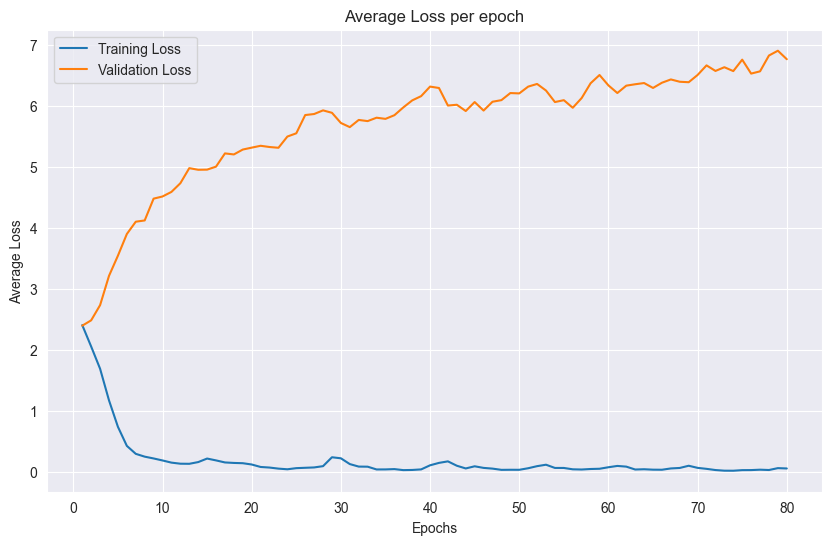

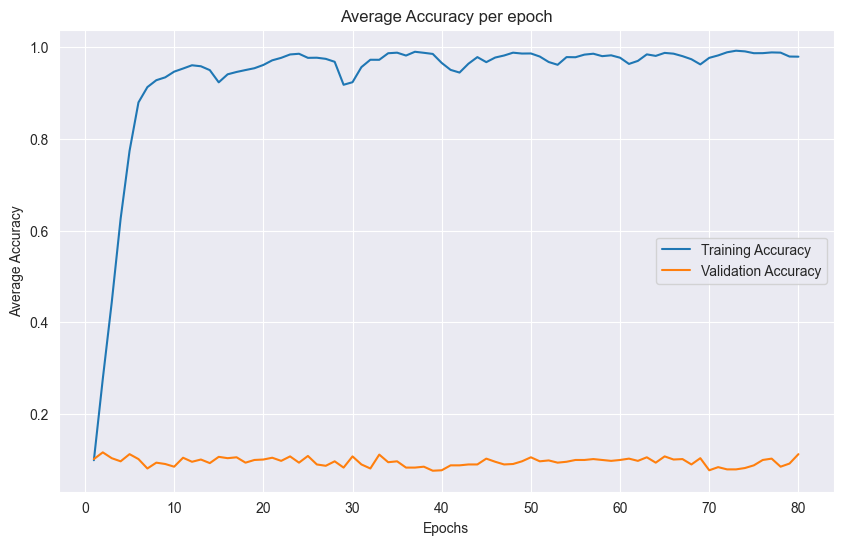

Overall Accuracy: 0.076


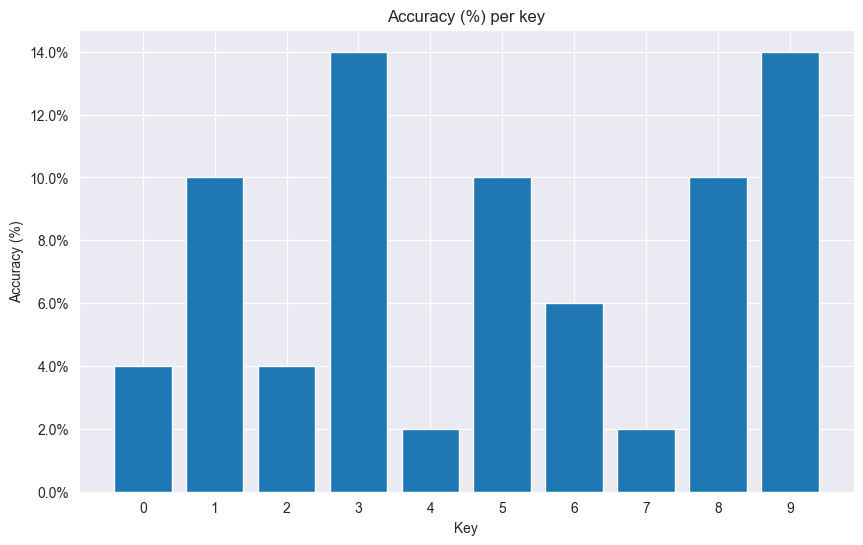

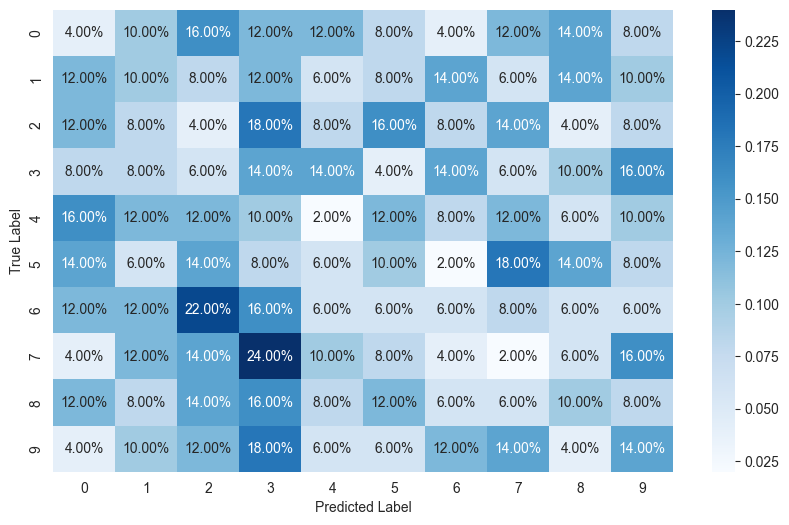

Accuracy for each key: 0: 4.0% 1: 10.0% 2: 4.0% 3: 14.0% 4: 2.0% 5: 10.0% 6: 6.0% 7: 2.0% 8: 10.0% 9: 14.0% 
              precision    recall  f1-score   support

           0       0.04      0.04      0.04        50
           1       0.10      0.10      0.10        50
           2       0.03      0.04      0.04        50
           3       0.09      0.14      0.11        50
           4       0.03      0.02      0.02        50
           5       0.11      0.10      0.11        50
           6       0.08      0.06      0.07        50
           7       0.02      0.02      0.02        50
           8       0.11      0.10      0.11        50
           9       0.13      0.14      0.14        50

    accuracy                           0.08       500
   macro avg       0.08      0.08      0.08       500
weighted avg       0.08      0.08      0.08       500

                    Model Parameters                    
Layer                    | Parameters
conv1.weight             : 64 * 4 * 7

In [20]:
def main():
    # setup parameters and load data
    batch_size = 32
    epochs = 80
    number_of_categories = 10
    
    X_train, X_val, X_test, y_train, y_val, y_test = importData()
    trainDataset = CSIDataset(X_train, y_train)
    valDataset = CSIDataset(X_val, y_val)
    
    trainLoader = DataLoader(trainDataset, shuffle=True, batch_size=batch_size)
    valLoader = DataLoader(valDataset, shuffle=True, batch_size=batch_size)

    model = ResNet_18(4, 10)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
    loss = nn.CrossEntropyLoss()

    # if (os.path.isfile("model.pth")):
    #     model.load_state_dict(torch.load('model.pth'))
    # else:
    #     train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
    #     # save the model
    #     torch.save(model.state_dict(), 'model.pth')
    #     plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
        
    train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
    plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
    torch.save(model.state_dict(), 'model_denoised_butter.pth')
    
    # Simple check with test dataset
    model.eval()
    testDataset = CSIDataset(X_test, y_test)
    testLoader = DataLoader(testDataset, shuffle=True, batch_size=X_test.shape[0])
    test(model, testLoader, X_test.shape[0])
    
    print_model_parameters(model)
    
main()

In [71]:
number_of_categories = 10
model = ResNet1D(64, 64, 3, 1, 1, 10, number_of_categories)
model.load_state_dict(torch.load('model_denoised_butter.pth'))
model.eval()

k = 3
extension = ".npy"
for file in os.listdir("../data/real_env"):
    if file.endswith(extension):
        print("========" + file + "========")
        y_batch = torch.tensor([[int(i)] for i in file.split("_")[0]], dtype=torch.float32)
        X_batch = torch.tensor(np.load("../data/real_env_denoised_butter/" + file), dtype=torch.float32)
        
        y_batch = y_batch.type(torch.LongTensor).squeeze(1)
        logits = model(X_batch)
        y_pred = F.log_softmax(logits, dim=1)
        
        predicted = np.argmax(y_pred.cpu().detach().numpy(), axis=1)
        print(f"Actual: " + f"{y_batch.tolist()}" + " Predicted: " f"{predicted}")
        values, indices = y_pred.topk(k)
        transposed_indx = torch.transpose(indices, 0, 1)
        print(f"Top k predictions: \n{transposed_indx.tolist()}")

========1436_table.npy========
Actual: [1, 4, 3, 6] Predicted: [2 2 9 0]
Top k predictions: 
[[2, 2, 9, 0], [3, 3, 3, 9], [8, 0, 0, 6]]
========1458_table.npy========
Actual: [1, 4, 5, 8] Predicted: [0 0 0 0]
Top k predictions: 
[[0, 0, 0, 0], [6, 9, 6, 9], [9, 6, 9, 6]]
========1524_table.npy========
Actual: [1, 5, 2, 4] Predicted: [4 4 4 4]
Top k predictions: 
[[4, 4, 4, 4], [1, 6, 6, 6], [6, 1, 1, 1]]
========2289_table.npy========
Actual: [2, 2, 8, 9] Predicted: [9 5 2 9]
Top k predictions: 
[[9, 5, 2, 9], [5, 9, 3, 0], [0, 8, 8, 5]]
========2379_table.npy========
Actual: [2, 3, 7, 9] Predicted: [4 4 4 4]
Top k predictions: 
[[4, 4, 4, 4], [1, 1, 1, 2], [7, 6, 7, 1]]
========3371_table.npy========
Actual: [3, 3, 7, 1] Predicted: [0 0 0 9]
Top k predictions: 
[[0, 0, 0, 9], [9, 9, 6, 0], [6, 6, 2, 5]]
========3917_table.npy========
Actual: [3, 9, 1, 7] Predicted: [2 2 4 4]
Top k predictions: 
[[2, 2, 4, 4], [4, 4, 2, 1], [1, 1, 1, 2]]
========4477_table.npy========
Actual: [4, 4, 7,